In [42]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from tqdm import tqdm
import matplotlib as mpl
from scipy.stats import binned_statistic_2d, binned_statistic
from numba import njit
import h5py as h5

import astropy.units as u

from joblib import Parallel, delayed

from dataclasses import dataclass

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

In [2]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

In [3]:
GFM_SOLAR_METALLICITY = 0.0127

GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_HELIUM  =  (1.-GFM_SOLAR_ABUNDANCE_HYDROGEN -GFM_SOLAR_METALLICITY)
GFM_SOLAR_ABUNDANCE_CARBON  =  0.0024
GFM_SOLAR_ABUNDANCE_NITROGEN =  0.0007
GFM_SOLAR_ABUNDANCE_OXYGEN  =  0.0057
GFM_SOLAR_ABUNDANCE_NEON    =  0.0012
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_SILICON =  0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013
GFM_SOLAR_ABUNDANCE_OTHER  =   0

HUBBLE = 3.2407789e-18
SEC_PER_MEGAYEAR = 3.15576e13

In [4]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    return ans

In [51]:
class EmptyClass:
    pass

def load_galaxy(snapnum, subID_99, rhalf_fac=2, phys=True, load_DM=False):
    # create output object
    galaxy = EmptyClass()
    
    # subID_99 is the subhalo ID at snapshot 99
    header = arepo.Snapshot(TNGbase, snapnum, onlyHeader=True)
    h = header.HubbleParam
    a = header.Time
    galaxy.header = header
    
    treeMPB = il.sublink.loadTree(TNGbase, 99, subID_99, onlyMPB=True)
    galaxy.treeMPB = treeMPB
    
    # retrieve subID and subhalo at given snapnum
    k_snap = int(np.where(treeMPB['SnapNum'] == snapnum)[0])
    subID = treeMPB['SubfindID'][k_snap]
    subhalo = il.groupcat.loadSingle(TNGbase, snapnum, subhaloID=subID)
    haloID = subhalo['SubhaloGrNr']
    halo = il.groupcat.loadSingle(TNGbase, snapnum, haloID=subhalo['SubhaloGrNr'])
    galaxy.subID = subID
    galaxy.subhalo = subhalo
    galaxy.halo = halo
    
    # load snapshot
    sn = EmptyClass()
    sn.part0 = il.snapshot.loadHalo(TNGbase, snapnum, haloID, 0)
    if load_DM:
        sn.part1 = il.snapshot.loadHalo(TNGbase, snapnum, haloID, 1)
    sn.part4 = il.snapshot.loadHalo(TNGbase, snapnum, haloID, 4)
    sn.part5 = il.snapshot.loadHalo(TNGbase, snapnum, haloID, 5)
    
    # get COM, COMV, and ang mom of stars
    COM = subhalo['SubhaloPos']
    pos = sn.part4['Coordinates'] - COM
    r = np.linalg.norm(pos, axis=1)
    
    # sort out stars within rhalf_fac*rhalf of origin
    rhalf = subhalo['SubhaloHalfmassRadType'][4]
    in_rhalf = r < rhalf_fac * rhalf
    is_star = sn.part4['GFM_StellarFormationTime'] > 0
    is_star_in_rhalf = np.logical_and(is_star, in_rhalf)
    
    # compute COMV as mass weighted average of stars in rhalf_fac*rhalf
    vel_in_rhalf = sn.part4['Velocities'][is_star_in_rhalf]
    mass_in_rhalf = sn.part4['Masses'][is_star_in_rhalf]
    COMV = np.average(vel_in_rhalf, axis=0, weights=mass_in_rhalf)
    
    vel = sn.part4['Velocities'] - COMV
    
    angmom = np.cross(pos[is_star_in_rhalf], vel[is_star_in_rhalf])
    angmom *= mass_in_rhalf.reshape(-1, 1)
    angmom = np.sum(angmom, axis=0)
    
    galaxy.CenterOfMass = EmptyClass()
    galaxy.CenterOfMass.Coordinate = COM
    galaxy.CenterOfMass.Velocity = COMV
    galaxy.CenterOfMass.AngularMomentum = angmom
    
    angmom_dir = angmom/np.linalg.norm(angmom)
    theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
    k = np.cross(angmom, np.array([0, 0, 1.]))
    k /= np.linalg.norm(k)

    galaxy.CenterOfMass.theta = theta
    galaxy.CenterOfMass.k = k
    
    for ptype in [0, 1, 4, 5]:
        if ptype==1 and load_DM is False:
            continue
        
        part = getattr(sn, 'part'+str(ptype))
        pos = part['Coordinates'] - COM
        vel = part['Velocities'] - COMV
    
        pos_rot = rodrigues_formula(k, pos.astype(np.float64), theta)
        vel_rot = rodrigues_formula(k, vel.astype(np.float64), theta)
        
        part['GalacticCoordinates'] = pos_rot
        part['GalacticVelocities'] = vel_rot
    
        part['GalacticCoordinatesPhys'] = pos_rot * a / h
        part['GalacticVelocitiesPhys'] = vel_rot * np.sqrt(a)
    
    galaxy.sn = sn
    
    return galaxy

In [44]:
subID = 523889

In [45]:
tracer = h5.File(basepath+'anlysTNG/tracer/subhalo'+str(subID)+'/props_subhalo'+str(subID)+'.h5', mode='r')

In [102]:
snapnum0 = 24
galaxy = {}

snapnum_list = np.arange(snapnum0, snapnum0 + 20*3)

for snapnum in tqdm(snapnum_list):
    galaxy[snapnum] = load_galaxy(snapnum, subID)

galaxy[99] = load_galaxy(99, subID)

100%|██████████| 60/60 [01:51<00:00,  1.86s/it]


In [103]:
pos = galaxy[99].sn.part4['GalacticCoordinatesPhys']
R = np.linalg.norm(pos[:,:2], axis=1)
in_SN = np.logical_and(np.logical_and(R > 6, R < 10), np.abs(pos[:,2]) < 3)

is_star = galaxy[99].sn.part4['GFM_StellarFormationTime'] > 0
is_star_in_SN = np.logical_and(is_star, in_SN)

Z = galaxy[99].sn.part4['GFM_Metallicity'] / GFM_SOLAR_METALLICITY
logZ = np.log10(Z)

FeH = galaxy[99].sn.part4['GFM_Metals'][:,8] / GFM_SOLAR_ABUNDANCE_IRON
logFeH = np.log10(FeH)

MgH = galaxy[99].sn.part4['GFM_Metals'][:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
MgFe = MgH/FeH
logMgFe = np.log10(MgFe)

a_born = galaxy[99].sn.part4['GFM_StellarFormationTime']
t_born = get_time(a_born)

# t0 = get_time(galaxy[48].header.Time) - 0.1
# t1 = get_time(galaxy[48].header.Time) + 0.1
# print(t0, t1)
# high_time = np.logical_and(t_born > t0, t_born < t1)
# high_Fe = np.logical_and(logFeH > -0.25, logFeH < 0.0)
# key_h = np.logical_and(np.logical_and(is_star_in_SN, high_time), high_Fe)

high_alpha = np.logical_and(MgFe > 2.25, MgFe < 3)
key_h = np.logical_and(high_alpha, is_star_in_SN)

# t0 = get_time(galaxy[50].header.Time) - 0.1
# t1 = get_time(galaxy[50].header.Time) + 0.1
# print(t0, t1)
# low_time = np.logical_and(t_born > t0, t_born < t1)
# low_Fe = np.logical_and(logFeH > -1, logFeH < -0.5)
# key_l = np.logical_and(np.logical_and(is_star_in_SN, low_time), low_Fe)

low_alpha = np.logical_and(MgFe > 1.75, MgFe < 2)
low_alpha = np.logical_and(np.logical_and(low_alpha, FeH > 0), FeH < 0.6)
key_l = np.logical_and(low_alpha, is_star_in_SN)

ParticleIDs_h = galaxy[99].sn.part4['ParticleIDs'][key_h]
ParticleIDs_l = galaxy[99].sn.part4['ParticleIDs'][key_l]

tkey_h = np.argwhere(np.isin(tracer['ParticleIDs'][99,:], ParticleIDs_h)).ravel()
tkey_l = np.argwhere(np.isin(tracer['ParticleIDs'][99,:], ParticleIDs_l)).ravel()

# high_alpha = logMgFe > 0.35
# key = np.logical_and(is_star_in_SN, high_alpha)
# ParticleIDs = galaxy[99].sn.part4['ParticleIDs'][key]
# tkey = np.argwhere(np.isin(tracer['ParticleIDs'][99,:], ParticleIDs)).ravel()

/tmp/ipykernel_3497696/4215798500.py:14: RuntimeWarning: invalid value encountered in sqrt
  ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))


100%|██████████| 60/60 [01:03<00:00,  1.06s/it]


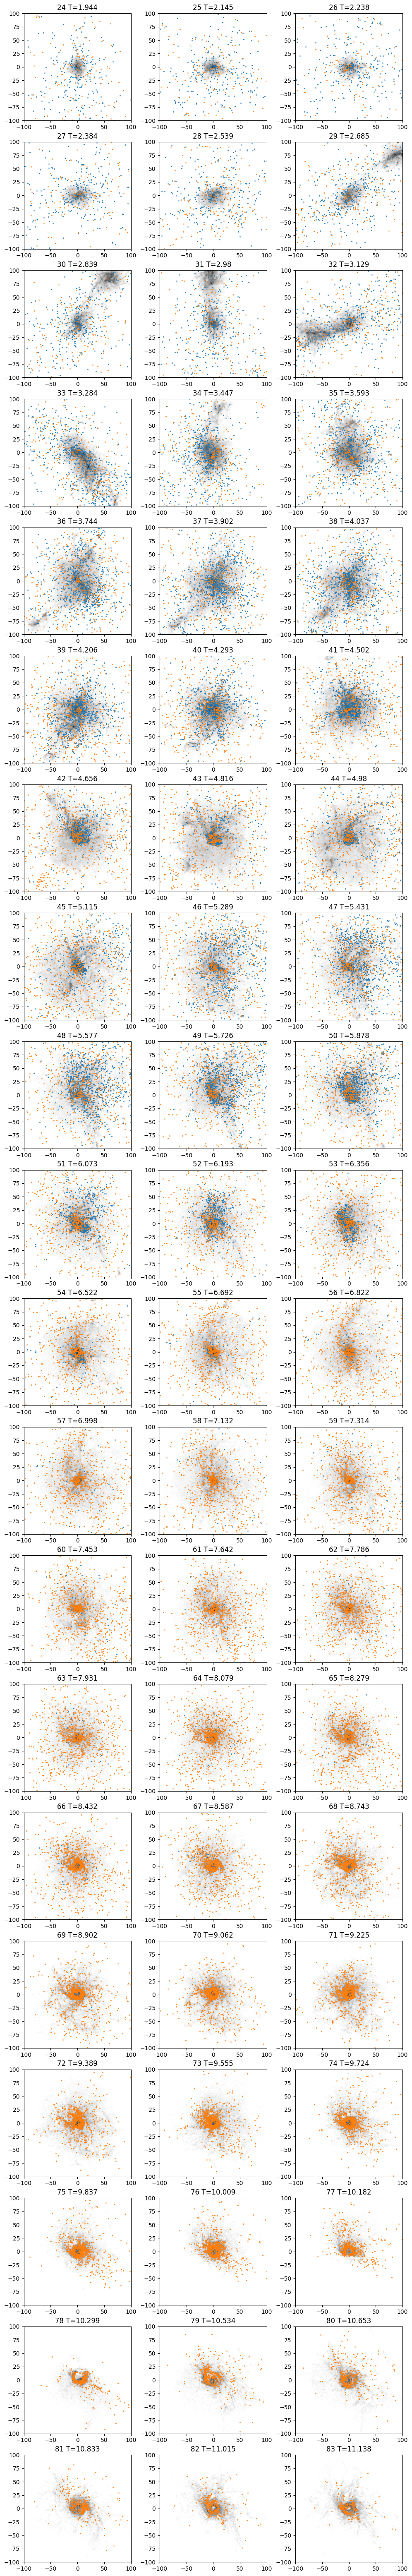

In [106]:
L = 200
nres = 256
vmax = 2E-2
vmin = 1E-4
cmap = 'Greys'

fig, ax = plt.subplots(20, 3, figsize=(12, 80))

for i,snapnum in enumerate(tqdm(snapnum_list)):
    # print(i)
    x = galaxy[snapnum].sn.part0['GalacticCoordinatesPhys'][:,0]
    y = galaxy[snapnum].sn.part0['GalacticCoordinatesPhys'][:,1]
    z = galaxy[snapnum].sn.part0['GalacticCoordinatesPhys'][:,2]
    m = galaxy[snapnum].sn.part0['Masses'] / galaxy[snapnum].header.HubbleParam
    
    k = galaxy[snapnum].CenterOfMass.k
    theta = galaxy[snapnum].CenterOfMass.theta
    
    tpos_h = tracer['Coordinates'][:][snapnum,tkey_h] - galaxy[snapnum].CenterOfMass.Coordinate
    tpos_h = rodrigues_formula(k, tpos_h.astype(np.float64), theta)
    tx_h = tpos_h[:,0]
    ty_h = tpos_h[:,1]
    tz_h = tpos_h[:,2]
    ptype_h = tracer['PartType'][:][snapnum,tkey_h]
    key_h = ptype_h == 0
    
    tpos_l = tracer['Coordinates'][:][snapnum,tkey_l] - galaxy[snapnum].CenterOfMass.Coordinate
    tpos_l = rodrigues_formula(k, tpos_l.astype(np.float64), theta)
    tx_l = tpos_l[:,0]
    ty_l = tpos_l[:,1]
    tz_l = tpos_l[:,2]
    ptype_l = tracer['PartType'][:][snapnum,tkey_l]
    key_l = ptype_l == 0
    
    # tpos = tracer['Coordinates'][:][snapnum,tkey] - galaxy[snapnum].CenterOfMass.Coordinate
    # tpos = rodrigues_formula(k, tpos.astype(np.float64), theta)
    # tx = tpos[:,0]
    # ty = tpos[:,1]
    # tz = tpos[:,2]
    # ptype = tracer['PartType'][:][snapnum,tkey]
    # key_t = np.where(ptype == 0)[0]
    
    key = np.abs(z) < L/2.
    
    xbins = np.linspace(-L/2., L/2., nres+1)
    ybins = np.linspace(-L/2., L/2., nres+1)
    
    dx = L / nres
    dy = L / nres
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(x[key], y[key], m[key], 
                                                     statistic='sum', bins=[xbins, ybins])
    mbin /= dx*dy
    
    ax_ = ax.ravel()[i]
    ax_.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
               norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)
    
    if len(np.where(key_h)[0]) > 1000:
        to_plot = np.random.choice(np.where(key_h)[0], 1000, replace=False)
    else:
        to_plot = key_h
    ax_.scatter(tx_h[to_plot], ty_h[to_plot], s=1)
    if len(np.where(key_l)[0]) > 1000:
        to_plot = np.random.choice(np.where(key_l)[0], 1000, replace=False)
    else:
        to_plot = key_l
    ax_.scatter(tx_l[to_plot], ty_l[to_plot], s=1)
    # to_plot = np.random.choice(np.where(key_t)[0], 1000, replace=False)
    # ax_.scatter(tx[to_plot], ty[to_plot], s=1)
    
    title = str(snapnum) + ' T=' + str(round(get_time(galaxy[snapnum].header.Time), 3))
    ax_.set(aspect='equal', title=title, xlim=(x_edge[0], x_edge[-1]), ylim=(y_edge[0], y_edge[-1]))

    # ax_.set(xlabel='time [Gyr]', ylabel='[Fe/H]')

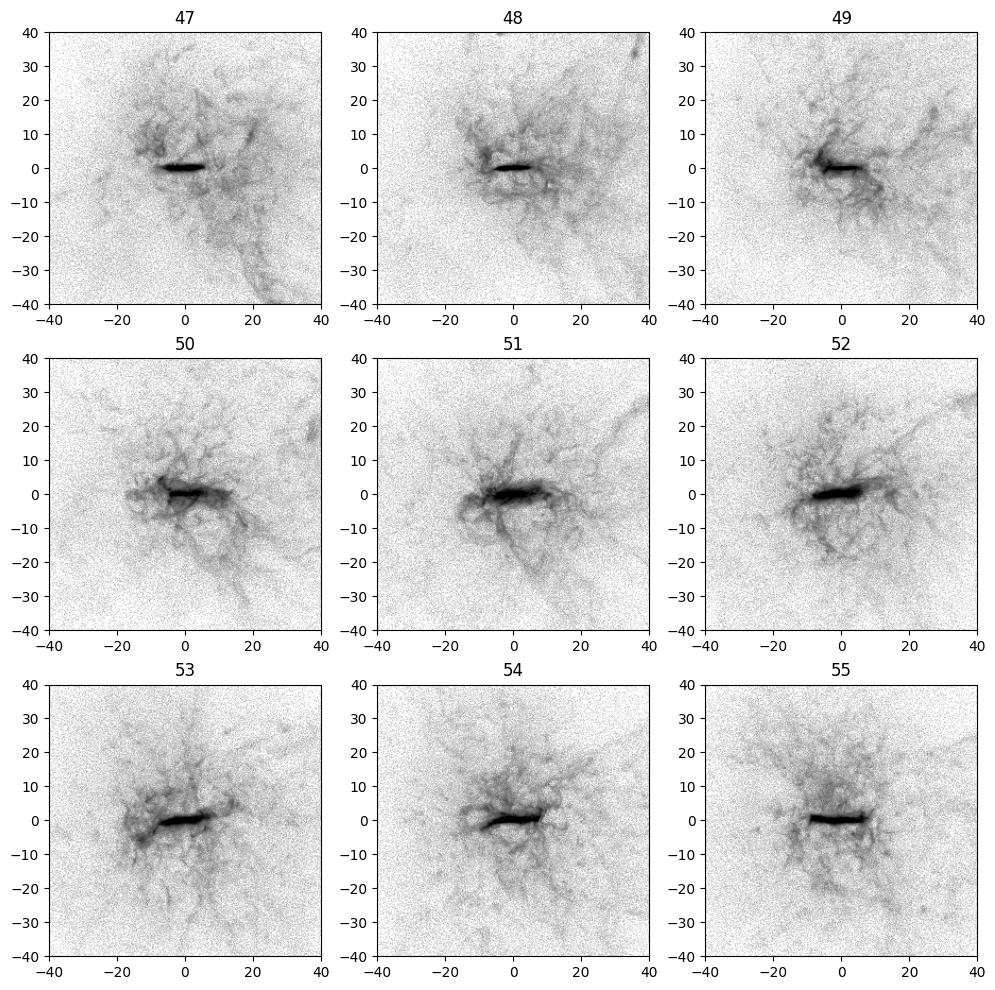

In [38]:
L = 80
nres = 256
vmax = 2E-2
vmin = 1E-4
cmap = 'Greys'

fig, ax = plt.subplots(3, 3, figsize=(12, 12))

for i,snapnum in enumerate(galaxy.keys()):
    x = galaxy[snapnum].sn.part0['GalacticCoordinatesPhys'][:,0]
    y = galaxy[snapnum].sn.part0['GalacticCoordinatesPhys'][:,1]
    z = galaxy[snapnum].sn.part0['GalacticCoordinatesPhys'][:,2]
    m = galaxy[snapnum].sn.part0['Masses'] / galaxy[snapnum].header.HubbleParam
    
    key = np.abs(z) < L/2.
    
    xbins = np.linspace(-L/2., L/2., nres+1)
    ybins = np.linspace(-L/2., L/2., nres+1)
    
    dx = L / nres
    dy = L / nres
    
    mbin, x_edge, y_edge, _ = binned_statistic_2d(x[key], z[key], m[key], 
                                                     statistic='sum', bins=[xbins, ybins])
    mbin /= dx*dy
    
    ax_ = ax.ravel()[i]
    ax_.imshow(mbin.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]],
               norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), cmap=cmap)
    ax_.set(aspect='equal', title=str(snapnum))

    # ax_.set(xlabel='time [Gyr]', ylabel='[Fe/H]')

In [24]:
np.percentile(mbin, 95)

0.001345745996804908

In [26]:
np.percentile(mbin, 15)

7.042806828394532e-05